In [ ]:
!pip install comet_ml --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 725.8/725.8 kB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 96.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import tensorflow as tf

from skimage.transform import resize
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array ,  load_img
from tensorflow.keras.models import Sequential , Model
from tensorflow.keras.layers import Dense , Conv2D , MaxPooling2D , Flatten
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.regularizers import l2, l1
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [ ]:
import comet_ml
from comet_ml import Optimizer, Experiment

comet_ml.init(project_name="comet-optimizer")

COMET WARNING: comet_ml.init() is deprecated and will be removed soon. Please use comet_ml.login()


Please paste your Comet API key from https://www.comet.com/api/my/settings/
(api key may not show as you type)
Comet API key: ··········


COMET INFO: Valid Comet API Key saved in /root/.comet.config (set COMET_CONFIG to change where it is saved).


In [ ]:
config = {
    "algorithm": "bayes",           # or "grid", "random"
    "name": "PersianDigit-BN-Experiment",
    "spec": {
        "maxCombo": 10,            # how many total combos to try
        "objective": "minimize",
        "metric": "loss",          # we'll log 'loss' as the key metric to minimize
    },
    "parameters": {
        "optimizer": {
            "type": "categorical",
            "values": ["sgd","adam"]
        },
        "reg_type": {
            "type": "categorical",
            "values": ["l1","l2"]
        },
        "reg_strength": {
            "type": "double",
            "min": 0.00001,
            "max": 0.01
        },
        "dropout_rate": {
            "type": "double",
            "min": 0.0,
            "max": 0.5
        },
        "learning_rate": {
            "type": "double",
            "min": 0.0001,
            "max": 0.01
        }
    },
    "trials": 1  # how many times to repeat each set of hyperparams
}

opt = Optimizer(config)

COMET INFO: 3cc8fea9875f4b6aa7dd77219523c157
COMET INFO: Using optimizer config: {'algorithm': 'bayes', 'configSpaceSize': 'infinite', 'endTime': None, 'id': '3cc8fea9875f4b6aa7dd77219523c157', 'lastUpdateTime': None, 'maxCombo': 10, 'name': 'PersianDigit-BN-Experiment', 'parameters': {'dropout_rate': {'max': 0.5, 'min': 0.0, 'scalingType': 'uniform', 'type': 'double'}, 'learning_rate': {'max': 0.01, 'min': 0.0001, 'scalingType': 'uniform', 'type': 'double'}, 'optimizer': {'type': 'categorical', 'values': ['sgd', 'adam']}, 'reg_strength': {'max': 0.01, 'min': 1e-05, 'scalingType': 'uniform', 'type': 'double'}, 'reg_type': {'type': 'categorical', 'values': ['l1', 'l2']}}, 'predictor': None, 'spec': {'gridSize': 10, 'maxCombo': 10, 'metric': 'loss', 'minSampleSize': 100, 'objective': 'minimize', 'retryAssignLimit': 0, 'retryLimit': 1000}, 'startTime': 3223766697, 'state': {'mode': None, 'seed': None, 'sequence': [], 'sequence_i': 0, 'sequence_pid': None, 'sequence_retry': 0, 'sequence_re

In [ ]:
#load dataset
mat_contents = sio.loadmat('Data_hoda_full.mat')

In [ ]:
#test and training set split
X_train_original = np.squeeze(mat_contents['Data'][:10000])
y_train_original = np.squeeze(mat_contents['labels'][:10000])
X_test_original = np.squeeze(mat_contents['Data'][10000:12000])
y_test_original = np.squeeze(mat_contents['labels'][10000:12000])

In [ ]:
X_train_original.shape

(10000,)

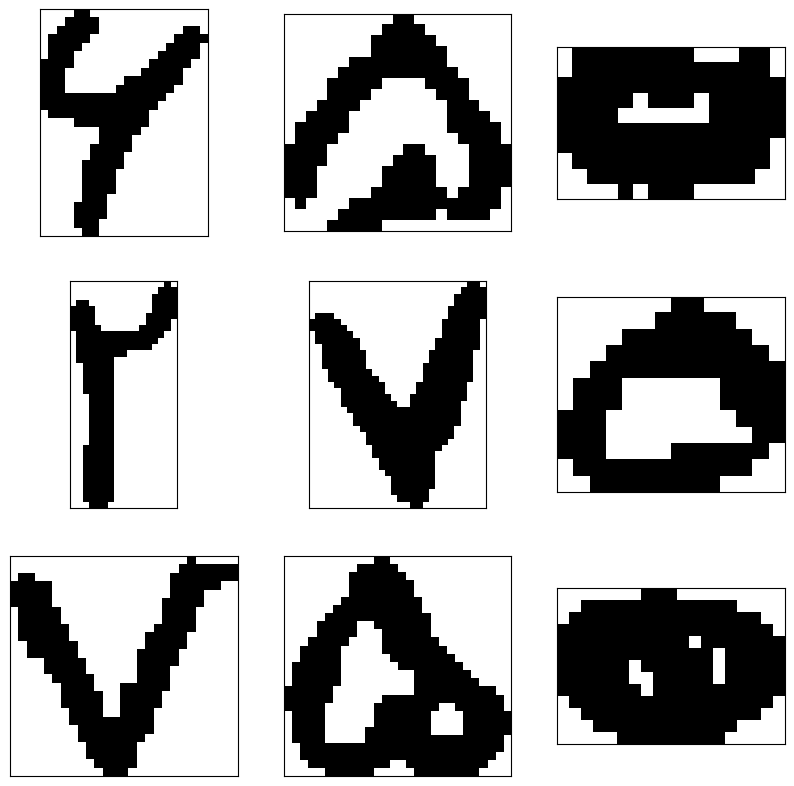

In [ ]:
plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train_original[i], cmap=plt.cm.binary)

plt.show()

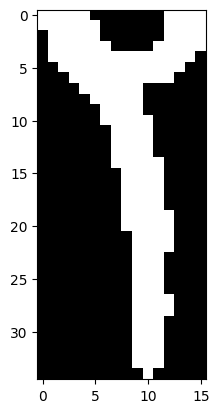

Label of 101th image is: 2


In [ ]:
i=101
image = X_train_original[i]
label = y_train_original[i]
plt.imshow(image, cmap='gray')
plt.show()
print("Label of {}th image is: {}".format(i, label))

In [ ]:
image.shape

(35, 16)

In [ ]:
image.dtype

dtype('uint8')

Resize Images

In [ ]:
# Reshape and normalize the data
img_rows, img_cols = 28, 28

def preprocess_data(data):
    """Resize images to (28,28) and normalize to [0,1]."""
    num_samples = data.shape[0]
    processed_data = np.zeros((num_samples, img_rows, img_cols, 1), dtype=np.float32)
    for i in range(num_samples):
        # Resize each image
        img = resize(data[i], (img_rows, img_cols))
        # Add channel dimension and normalize
        img = img.reshape(img_rows, img_cols, 1)
        img = img / 255.0
        processed_data[i] = img
    return processed_data

In [ ]:
# Preprocess input data for Keras.
X_train = preprocess_data(X_train_original)
X_test  = preprocess_data(X_test_original)

# One-hot encode labels
y_train = to_categorical(y_train_original, num_classes=10)
y_test  = to_categorical(y_test_original, num_classes=10)

# Create a validation set from the training data
X_train_part, X_val, y_train_part, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

In [ ]:
# Define your  model
# compile the model
def build_model(experiment):
  model = Sequential()
  model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(28,28,1)))
  model.add(MaxPooling2D(pool_size=(2,2), strides=1))
  model.add(Conv2D(filters=32, kernel_size=(3,3), input_shape=(28,28,1)))
  model.add(MaxPooling2D(pool_size=(2,2), strides=1))
  model.add(Flatten())
  model.add(Dense(64 , activation='relu'))
  model.add(Dense(32 , activation='relu'))
  model.add(Dense(16 , activation='relu'))
  model.add(Dense(10 , activation='softmax'))
  model.compile(optimizer='adam' , loss='categorical_crossentropy' , metrics=['accuracy'])
  return model

In [ ]:
model = build_model(experiment=None)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 25, 25, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 23, 23, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 22, 22, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 15488)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │         991,296 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 10)                  │             170 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,003,642 (3.83 MB)

 Trainable params: 1,003,642 (3.83 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Train  model
def train(experiment, model, X_train, y_train, X_val, y_val, X_test, y_test):
    """Train the model with a validation set, log metrics, and return test loss."""
    history = model.fit(
        X_train,
        y_train,
        validation_data=(X_val, y_val),
        epochs=10,
        batch_size=64,
        verbose=2
    )

    # --- Plot Loss ---
    plt.figure()
    plt.plot(history.history["loss"], label="train_loss")
    plt.plot(history.history["val_loss"], label="val_loss")
    plt.title("Loss vs. Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

    # --- Plot Accuracy ---
    plt.figure()
    plt.plot(history.history["accuracy"], label="train_accuracy")
    plt.plot(history.history["val_accuracy"], label="val_accuracy")
    plt.title("Accuracy vs. Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    experiment.log_metric("loss", test_loss)
    experiment.log_metric("accuracy", test_acc)

    # Additional metrics
    y_pred_prob = model.predict(X_test)
    y_pred = np.argmax(y_pred_prob, axis=1)
    y_true = np.argmax(y_test, axis=1)

    prec = precision_score(y_true, y_pred, average="macro")
    rec  = recall_score(y_true, y_pred, average="macro")
    f1   = f1_score(y_true, y_pred, average="macro")

    experiment.log_metric("precision", prec)
    experiment.log_metric("recall", rec)
    experiment.log_metric("f1_score", f1)

    print(f"[INFO] Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")
    print(f"[INFO] Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")

    return test_loss  # Return test loss for ranking

In [ ]:
#  Use the evaluate method to test the model
def evaluate(experiment, model, X_test, y_test):
    """Quick evaluation of the model on test set."""
    score = model.evaluate(X_test, y_test, verbose=0)
    print(f"[INFO] Evaluate - Test Loss: {score[0]:.4f}, Test Accuracy: {score[1]:.4f}")

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: keras, tensorflow, sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/arhorri/comet-optimizer/aca8cfac9f9d4e76a7649a10d91b3535

COMET INFO: Couldn't find a Git repository in '/content' nor in any parent directory. Set `COMET_GIT_DIRECTORY` if your Git Repository is elsewhere.


Epoch 1/10
125/125 - 8s - 64ms/step - accuracy: 0.5941 - loss: 1.1501 - val_accuracy: 0.8460 - val_loss: 0.4801
Epoch 2/10
125/125 - 1s - 5ms/step - accuracy: 0.8898 - loss: 0.3324 - val_accuracy: 0.9320 - val_loss: 0.2170
Epoch 3/10
125/125 - 1s - 5ms/step - accuracy: 0.9352 - loss: 0.1959 - val_accuracy: 0.9550 - val_loss: 0.1435
Epoch 4/10
125/125 - 1s - 5ms/step - accuracy: 0.9571 - loss: 0.1376 - val_accuracy: 0.9690 - val_loss: 0.1195
Epoch 5/10
125/125 - 1s - 5ms/step - accuracy: 0.9655 - loss: 0.1100 - val_accuracy: 0.9680 - val_loss: 0.1135
Epoch 6/10
125/125 - 1s - 5ms/step - accuracy: 0.9706 - loss: 0.0943 - val_accuracy: 0.9620 - val_loss: 0.1154
Epoch 7/10
125/125 - 1s - 10ms/step - accuracy: 0.9710 - loss: 0.0856 - val_accuracy: 0.9730 - val_loss: 0.0913
Epoch 8/10
125/125 - 1s - 5ms/step - accuracy: 0.9760 - loss: 0.0712 - val_accuracy: 0.9780 - val_loss: 0.0782
Epoch 9/10
125/125 - 1s - 5ms/step - accuracy: 0.9776 - loss: 0.0609 - val_accuracy: 0.9720 - val_loss: 0.0958

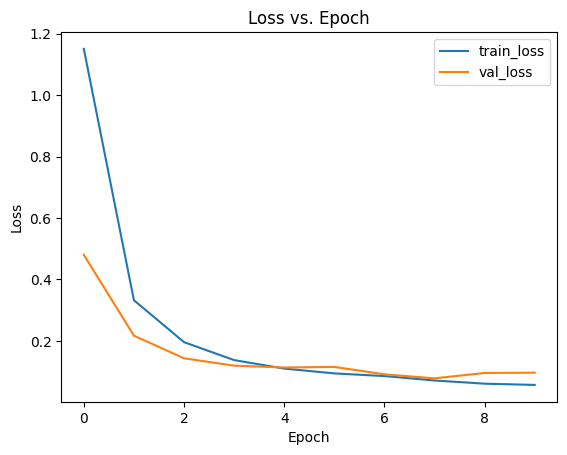

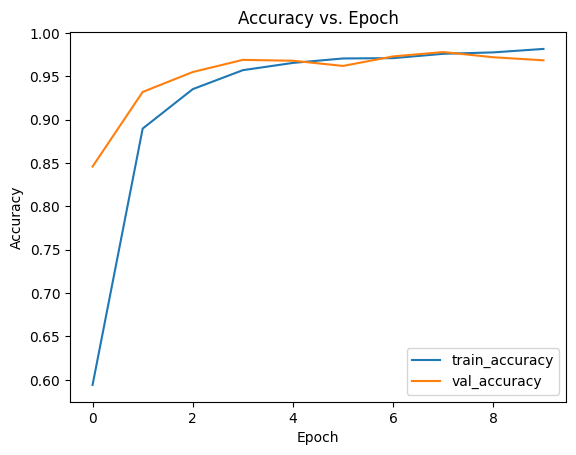

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
[INFO] Test Loss: 0.1481, Test Accuracy: 0.9645
[INFO] Precision: 0.9653, Recall: 0.9645, F1: 0.9647
[INFO] Evaluate - Test Loss: 0.1481, Test Accuracy: 0.9645


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : parental_tuna_8127
COMET INFO:     url                   : https://www.comet.com/arhorri/comet-optimizer/aca8cfac9f9d4e76a7649a10d91b3535
COMET INFO:   Metrics:
COMET INFO:     accuracy  : 0.9645000100135803
COMET INFO:     f1_score  : 0.9646880701219518
COMET INFO:     loss      : 0.14810623228549957
COMET INFO:     precision : 0.96530211042687
COMET INFO:     recall    : 0.9644875691857269
COMET INFO:   Others:
COMET INFO:     notebook_url           : https://colab.research.google.com/notebook#fileId=1dtZIjJZoFCeVNP3gVnlc0fnENyqLDnro
COMET INFO:     optimizer_count        : 1
COMET INFO:     optimizer_id           : 3cc8fea9875f4b6aa7dd77219523c157

Epoch 1/10
125/125 - 4s - 34ms/step - accuracy: 0.5814 - loss: 1.2714 - val_accuracy: 0.9110 - val_loss: 0.2618
Epoch 2/10
125/125 - 1s - 5ms/step - accuracy: 0.9215 - loss: 0.2610 - val_accuracy: 0.9365 - val_loss: 0.1802
Epoch 3/10
125/125 - 1s - 5ms/step - accuracy: 0.9499 - loss: 0.1688 - val_accuracy: 0.9555 - val_loss: 0.1262
Epoch 4/10
125/125 - 1s - 5ms/step - accuracy: 0.9595 - loss: 0.1303 - val_accuracy: 0.9660 - val_loss: 0.1138
Epoch 5/10
125/125 - 1s - 5ms/step - accuracy: 0.9688 - loss: 0.0968 - val_accuracy: 0.9760 - val_loss: 0.0806
Epoch 6/10
125/125 - 1s - 4ms/step - accuracy: 0.9736 - loss: 0.0822 - val_accuracy: 0.9740 - val_loss: 0.0796
Epoch 7/10
125/125 - 1s - 5ms/step - accuracy: 0.9765 - loss: 0.0694 - val_accuracy: 0.9625 - val_loss: 0.1041
Epoch 8/10
125/125 - 1s - 4ms/step - accuracy: 0.9765 - loss: 0.0667 - val_accuracy: 0.9700 - val_loss: 0.0818
Epoch 9/10
125/125 - 1s - 5ms/step - accuracy: 0.9775 - loss: 0.0641 - val_accuracy: 0.9755 - val_loss: 0.0718


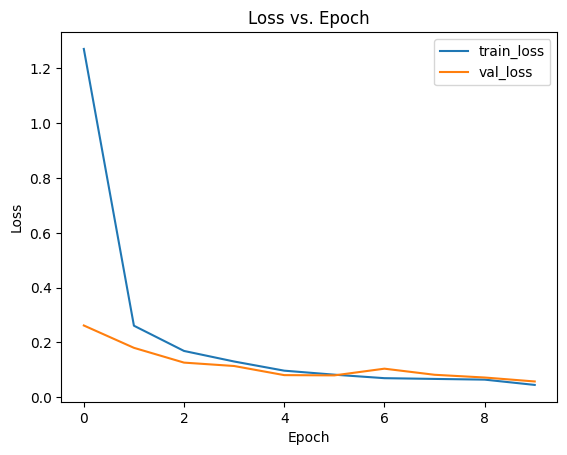

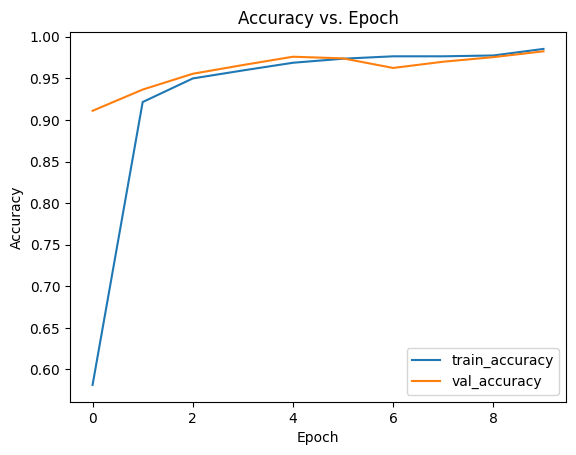

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
[INFO] Test Loss: 0.1277, Test Accuracy: 0.9735
[INFO] Precision: 0.9737, Recall: 0.9735, F1: 0.9735
[INFO] Evaluate - Test Loss: 0.1277, Test Accuracy: 0.9735


COMET WARNING: Couldn't retrieve and log Google Colab notebook content, reason: 'NoneType' object is not subscriptable
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : distant_olive_5249
COMET INFO:     url                   : https://www.comet.com/arhorri/comet-optimizer/51ceea9d31174b6fa2a31c0fd50ae3dc
COMET INFO:   Metrics:
COMET INFO:     accuracy  : 0.9735000133514404
COMET INFO:     f1_score  : 0.9735216405875378
COMET INFO:     loss      : 0.12771546840667725
COMET INFO:     precision : 0.9737039480573783
COMET INFO:     recall    : 0.9735398694927078
COMET INFO:   Others:
COMET INFO:     notebook_url           : https://colab.research.google.com/notebook#fileId=1dtZIjJZoFCeVNP3gVnlc0fnENyqL

Epoch 1/10
125/125 - 4s - 35ms/step - accuracy: 0.5449 - loss: 1.3383 - val_accuracy: 0.8965 - val_loss: 0.3646
Epoch 2/10
125/125 - 3s - 25ms/step - accuracy: 0.9162 - loss: 0.2755 - val_accuracy: 0.9400 - val_loss: 0.2022
Epoch 3/10
125/125 - 1s - 9ms/step - accuracy: 0.9463 - loss: 0.1764 - val_accuracy: 0.9505 - val_loss: 0.1611
Epoch 4/10
125/125 - 1s - 4ms/step - accuracy: 0.9567 - loss: 0.1398 - val_accuracy: 0.9470 - val_loss: 0.1628
Epoch 5/10
125/125 - 1s - 5ms/step - accuracy: 0.9621 - loss: 0.1146 - val_accuracy: 0.9650 - val_loss: 0.1059
Epoch 6/10
125/125 - 1s - 5ms/step - accuracy: 0.9693 - loss: 0.0963 - val_accuracy: 0.9680 - val_loss: 0.1044
Epoch 7/10
125/125 - 1s - 5ms/step - accuracy: 0.9699 - loss: 0.0895 - val_accuracy: 0.9680 - val_loss: 0.1098
Epoch 8/10
125/125 - 1s - 5ms/step - accuracy: 0.9758 - loss: 0.0725 - val_accuracy: 0.9640 - val_loss: 0.1108
Epoch 9/10
125/125 - 1s - 5ms/step - accuracy: 0.9765 - loss: 0.0660 - val_accuracy: 0.9705 - val_loss: 0.1033

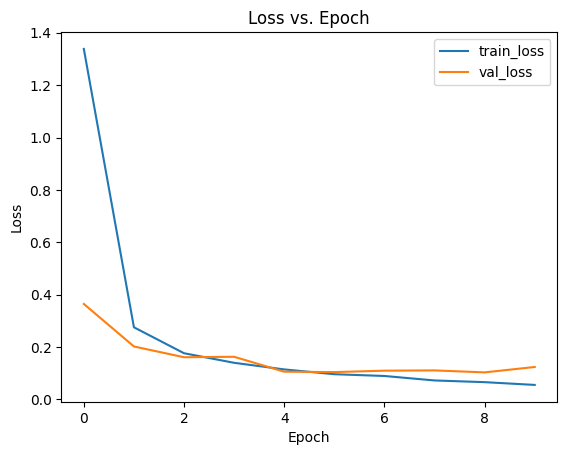

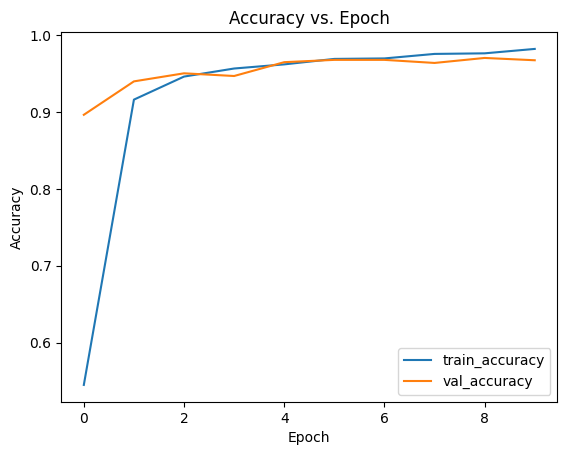

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
[INFO] Test Loss: 0.1706, Test Accuracy: 0.9610
[INFO] Precision: 0.9610, Recall: 0.9611, F1: 0.9608
[INFO] Evaluate - Test Loss: 0.1706, Test Accuracy: 0.9610


COMET WARNING: Couldn't retrieve and log Google Colab notebook content, reason: 'NoneType' object is not subscriptable
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : sophisticated_subfloor_4442
COMET INFO:     url                   : https://www.comet.com/arhorri/comet-optimizer/cb8dba6a886240749893b495b9f03076
COMET INFO:   Metrics:
COMET INFO:     accuracy  : 0.9610000252723694
COMET INFO:     f1_score  : 0.9607752063899611
COMET INFO:     loss      : 0.1705835908651352
COMET INFO:     precision : 0.9610212363443715
COMET INFO:     recall    : 0.9610502582589092
COMET INFO:   Others:
COMET INFO:     notebook_url           : https://colab.research.google.com/notebook#fileId=1dtZIjJZoFCeVNP3gVnlc

Epoch 1/10
125/125 - 4s - 33ms/step - accuracy: 0.5853 - loss: 1.2307 - val_accuracy: 0.8800 - val_loss: 0.3779
Epoch 2/10
125/125 - 1s - 5ms/step - accuracy: 0.9078 - loss: 0.2983 - val_accuracy: 0.9375 - val_loss: 0.1989
Epoch 3/10
125/125 - 1s - 5ms/step - accuracy: 0.9444 - loss: 0.1767 - val_accuracy: 0.9410 - val_loss: 0.1709
Epoch 4/10
125/125 - 1s - 5ms/step - accuracy: 0.9534 - loss: 0.1446 - val_accuracy: 0.9590 - val_loss: 0.1234
Epoch 5/10
125/125 - 1s - 5ms/step - accuracy: 0.9626 - loss: 0.1189 - val_accuracy: 0.9605 - val_loss: 0.1219
Epoch 6/10
125/125 - 1s - 5ms/step - accuracy: 0.9661 - loss: 0.1085 - val_accuracy: 0.9690 - val_loss: 0.0864
Epoch 7/10
125/125 - 1s - 10ms/step - accuracy: 0.9711 - loss: 0.0918 - val_accuracy: 0.9680 - val_loss: 0.1076
Epoch 8/10
125/125 - 1s - 5ms/step - accuracy: 0.9758 - loss: 0.0792 - val_accuracy: 0.9710 - val_loss: 0.0890
Epoch 9/10
125/125 - 1s - 5ms/step - accuracy: 0.9764 - loss: 0.0661 - val_accuracy: 0.9635 - val_loss: 0.1098

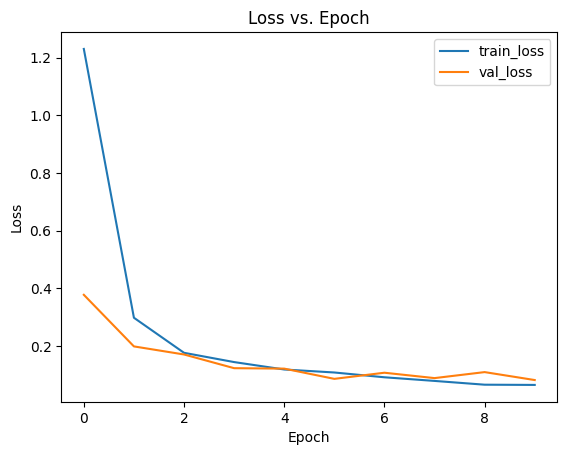

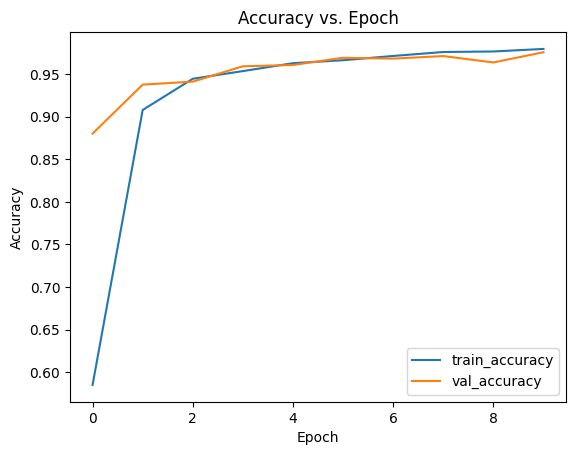

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
[INFO] Test Loss: 0.1290, Test Accuracy: 0.9685
[INFO] Precision: 0.9691, Recall: 0.9684, F1: 0.9685
[INFO] Evaluate - Test Loss: 0.1290, Test Accuracy: 0.9685


COMET WARNING: Couldn't retrieve and log Google Colab notebook content, reason: 'NoneType' object is not subscriptable
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : chocolate_puffin_6298
COMET INFO:     url                   : https://www.comet.com/arhorri/comet-optimizer/2fb49d57e8244483bbb8578bdacd295e
COMET INFO:   Metrics:
COMET INFO:     accuracy  : 0.968500018119812
COMET INFO:     f1_score  : 0.9685383543302992
COMET INFO:     loss      : 0.12898923456668854
COMET INFO:     precision : 0.9691248900122449
COMET INFO:     recall    : 0.9683747636532299
COMET INFO:   Others:
COMET INFO:     notebook_url           : https://colab.research.google.com/notebook#fileId=1dtZIjJZoFCeVNP3gVnlc0fnENy

Epoch 1/10
125/125 - 4s - 30ms/step - accuracy: 0.5590 - loss: 1.2594 - val_accuracy: 0.9165 - val_loss: 0.3268
Epoch 2/10
125/125 - 1s - 8ms/step - accuracy: 0.9312 - loss: 0.2421 - val_accuracy: 0.9510 - val_loss: 0.1666
Epoch 3/10
125/125 - 1s - 5ms/step - accuracy: 0.9565 - loss: 0.1479 - val_accuracy: 0.9625 - val_loss: 0.1151
Epoch 4/10
125/125 - 1s - 5ms/step - accuracy: 0.9665 - loss: 0.1136 - val_accuracy: 0.9635 - val_loss: 0.1047
Epoch 5/10
125/125 - 1s - 5ms/step - accuracy: 0.9650 - loss: 0.1113 - val_accuracy: 0.9655 - val_loss: 0.1132
Epoch 6/10
125/125 - 1s - 5ms/step - accuracy: 0.9718 - loss: 0.0875 - val_accuracy: 0.9700 - val_loss: 0.1052
Epoch 7/10
125/125 - 1s - 5ms/step - accuracy: 0.9759 - loss: 0.0768 - val_accuracy: 0.9745 - val_loss: 0.0723
Epoch 8/10
125/125 - 1s - 5ms/step - accuracy: 0.9797 - loss: 0.0605 - val_accuracy: 0.9735 - val_loss: 0.0817
Epoch 9/10
125/125 - 1s - 6ms/step - accuracy: 0.9804 - loss: 0.0566 - val_accuracy: 0.9705 - val_loss: 0.1061


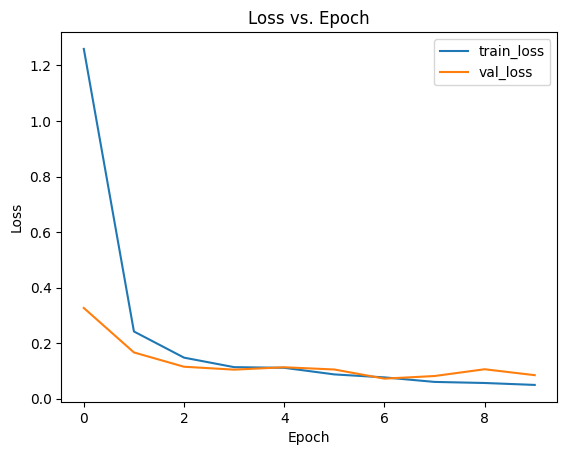

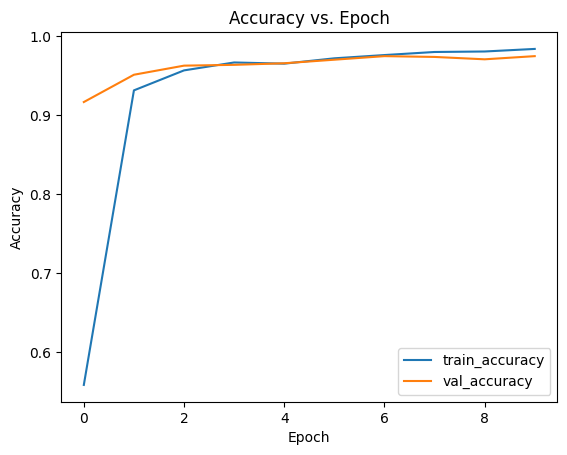

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
[INFO] Test Loss: 0.1417, Test Accuracy: 0.9640
[INFO] Precision: 0.9652, Recall: 0.9634, F1: 0.9640
[INFO] Evaluate - Test Loss: 0.1417, Test Accuracy: 0.9640


COMET WARNING: Couldn't retrieve and log Google Colab notebook content, reason: 'NoneType' object is not subscriptable
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : coherent_beer_2138
COMET INFO:     url                   : https://www.comet.com/arhorri/comet-optimizer/570ad01e9f3648cdbf62097e73792d94
COMET INFO:   Metrics:
COMET INFO:     accuracy  : 0.9639999866485596
COMET INFO:     f1_score  : 0.9639739066553619
COMET INFO:     loss      : 0.14166046679019928
COMET INFO:     precision : 0.9652230430702005
COMET INFO:     recall    : 0.963444302982227
COMET INFO:   Others:
COMET INFO:     notebook_url           : https://colab.research.google.com/notebook#fileId=1dtZIjJZoFCeVNP3gVnlc0fnENyqLD

Epoch 1/10
Epoch 1/10
125/125 - 4s - 30ms/step - accuracy: 0.5764 - loss: 1.1794 - val_accuracy: 0.8965 - val_loss: 0.3254
125/125 - 4s - 30ms/step - accuracy: 0.5764 - loss: 1.1794 - val_accuracy: 0.8965 - val_loss: 0.3254
Epoch 2/10
Epoch 2/10
125/125 - 1s - 5ms/step - accuracy: 0.9246 - loss: 0.2486 - val_accuracy: 0.9245 - val_loss: 0.2187
125/125 - 1s - 5ms/step - accuracy: 0.9246 - loss: 0.2486 - val_accuracy: 0.9245 - val_loss: 0.2187
Epoch 3/10
Epoch 3/10
125/125 - 1s - 5ms/step - accuracy: 0.9517 - loss: 0.1589 - val_accuracy: 0.9600 - val_loss: 0.1392
125/125 - 1s - 5ms/step - accuracy: 0.9517 - loss: 0.1589 - val_accuracy: 0.9600 - val_loss: 0.1392
Epoch 4/10
Epoch 4/10
125/125 - 1s - 5ms/step - accuracy: 0.9653 - loss: 0.1221 - val_accuracy: 0.9605 - val_loss: 0.1301
125/125 - 1s - 5ms/step - accuracy: 0.9653 - loss: 0.1221 - val_accuracy: 0.9605 - val_loss: 0.1301
Epoch 5/10
Epoch 5/10
125/125 - 1s - 5ms/step - accuracy: 0.9679 - loss: 0.1020 - val_accuracy: 0.9640 - val_l

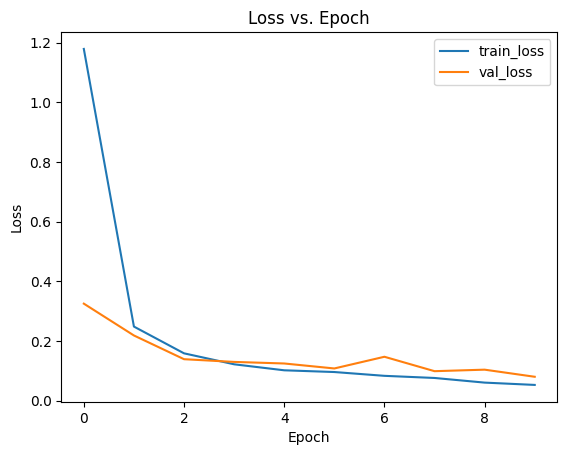

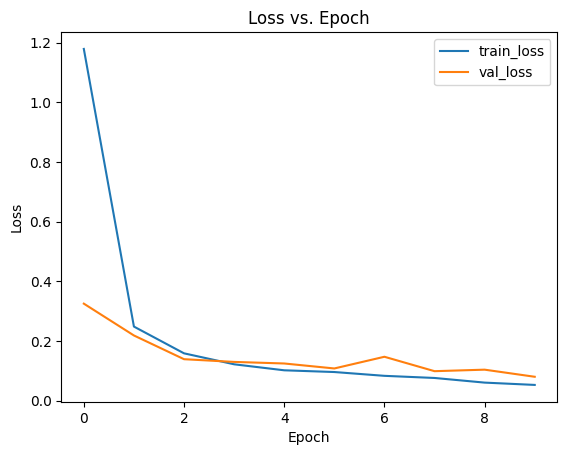

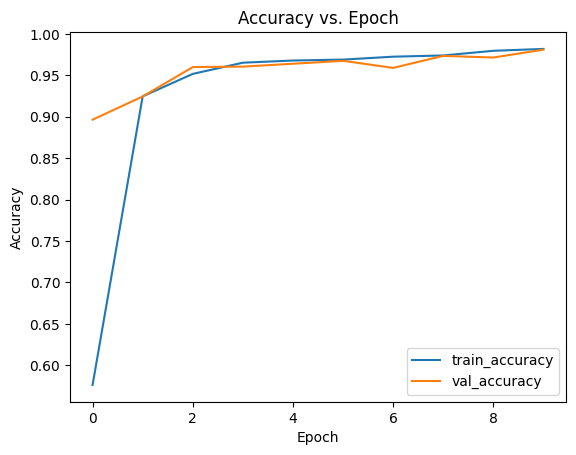

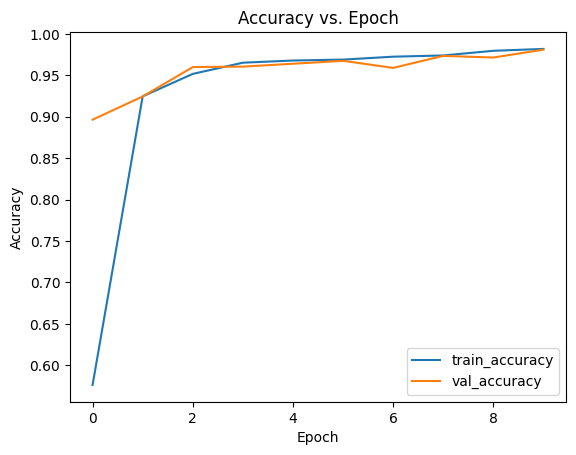

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
[INFO] Test Loss: 0.1306, Test Accuracy: 0.9670
[INFO] Precision: 0.9676, Recall: 0.9665, F1: 0.9669
[INFO] Test Loss: 0.1306, Test Accuracy: 0.9670
[INFO] Precision: 0.9676, Recall: 0.9665, F1: 0.9669
[INFO] Evaluate - Test Loss: 0.1306, Test Accuracy: 0.9670
[INFO] Evaluate - Test Loss: 0.1306, Test Accuracy: 0.9670


COMET WARNING: Couldn't retrieve and log Google Colab notebook content, reason: 'NoneType' object is not subscriptable
COMET WARNING: Couldn't retrieve and log Google Colab notebook content, reason: 'NoneType' object is not subscriptable
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : indigo_haddock_453
COMET INFO:     name                  : indigo_haddock_453
COMET INFO:     url                   : 

Epoch 1/10
Epoch 1/10
125/125 - 4s - 30ms/step - accuracy: 0.4971 - loss: 1.4127 - val_accuracy: 0.8760 - val_loss: 0.4617
125/125 - 4s - 30ms/step - accuracy: 0.4971 - loss: 1.4127 - val_accuracy: 0.8760 - val_loss: 0.4617
Epoch 2/10
Epoch 2/10
125/125 - 1s - 9ms/step - accuracy: 0.9110 - loss: 0.3046 - val_accuracy: 0.9420 - val_loss: 0.1921
125/125 - 1s - 9ms/step - accuracy: 0.9110 - loss: 0.3046 - val_accuracy: 0.9420 - val_loss: 0.1921
Epoch 3/10
Epoch 3/10
125/125 - 1s - 10ms/step - accuracy: 0.9505 - loss: 0.1654 - val_accuracy: 0.9665 - val_loss: 0.1279
125/125 - 1s - 10ms/step - accuracy: 0.9505 - loss: 0.1654 - val_accuracy: 0.9665 - val_loss: 0.1279
Epoch 4/10
Epoch 4/10
125/125 - 1s - 5ms/step - accuracy: 0.9628 - loss: 0.1225 - val_accuracy: 0.9685 - val_loss: 0.1089
125/125 - 1s - 5ms/step - accuracy: 0.9628 - loss: 0.1225 - val_accuracy: 0.9685 - val_loss: 0.1089
Epoch 5/10
Epoch 5/10
125/125 - 1s - 5ms/step - accuracy: 0.9659 - loss: 0.1016 - val_accuracy: 0.9620 - val

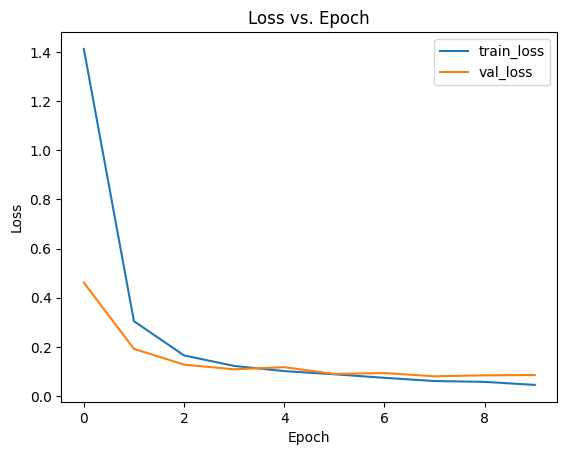

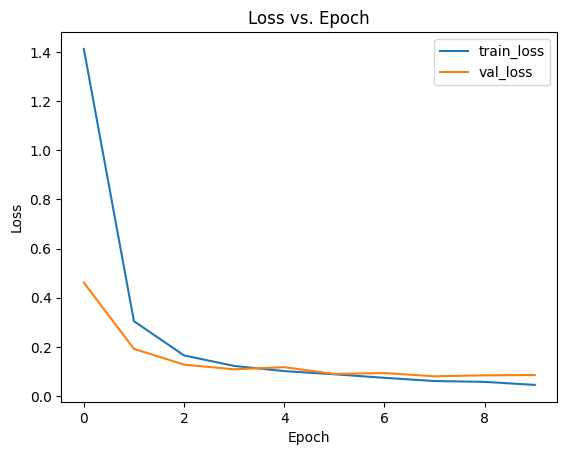

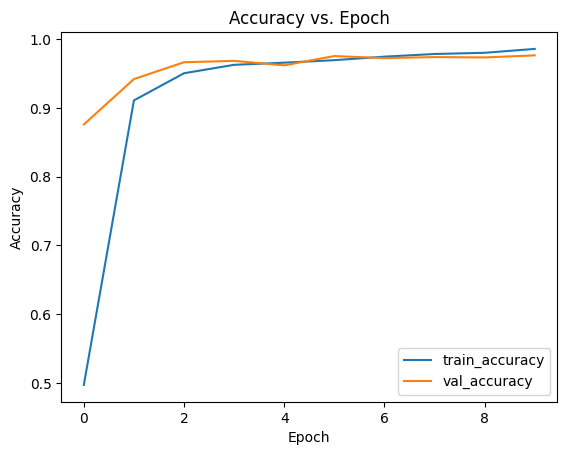

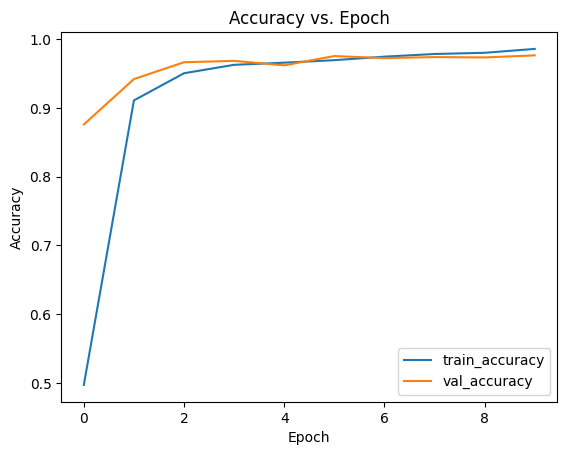

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
[INFO] Test Loss: 0.1526, Test Accuracy: 0.9615
[INFO] Precision: 0.9621, Recall: 0.9617, F1: 0.9614
[INFO] Test Loss: 0.1526, Test Accuracy: 0.9615
[INFO] Precision: 0.9621, Recall: 0.9617, F1: 0.9614
[INFO] Evaluate - Test Loss: 0.1526, Test Accuracy: 0.9615
[INFO] Evaluate - Test Loss: 0.1526, Test Accuracy: 0.9615


COMET WARNING: Couldn't retrieve and log Google Colab notebook content, reason: 'NoneType' object is not subscriptable
COMET WARNING: Couldn't retrieve and log Google Colab notebook content, reason: 'NoneType' object is not subscriptable
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : coastal_parrot_5165
COMET INFO:     name                  : coastal_parrot_5165
COMET INFO:     url                   

Epoch 1/10
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 - 4s - 30ms/step - accuracy: 0.5658 - loss: 1.2059 - val_accuracy: 0.9030 - val_loss: 0.3128
125/125 - 4s - 30ms/step - accuracy: 0.5658 - loss: 1.2059 - val_accuracy: 0.9030 - val_loss: 0.3128
Epoch 2/10
Epoch 2/10
125/125 - 1s - 5ms/step - accuracy: 0.9236 - loss: 0.2564 - val_accuracy: 0.9460 - val_loss: 0.1850
125/125 - 1s - 5ms/step - accuracy: 0.9236 - loss: 0.2564 - val_accuracy: 0.9460 - val_loss: 0.1850
Epoch 3/10
Epoch 3/10
125/125 - 1s - 5ms/step - accuracy: 0.9475 - loss: 0.1741 - val_accuracy: 0.9550 - val_loss: 0.1537
125/125 - 1s - 5ms/step - accuracy: 0.9475 - loss: 0.1741 - val_accuracy: 0.9550 - val_loss: 0.1537
Epoch 4/10
Epoch 4/10
125/125 - 1s - 5ms/step - accuracy: 0.9566 - loss: 0.1414 - val_accuracy: 0.9660 - val_loss: 0.1257
125/125 - 1s - 5ms/step - accuracy: 0.9566 - loss: 0.1414 - val_accuracy: 0.9660 - val_loss: 0.1257
Epoch 5/10
Epoch 5/10
125/125 - 1s - 10ms/step - accuracy: 0.9644 - loss: 0.1146 - val_accuracy: 0.9660 - val_loss: 0.1180
125/125 -

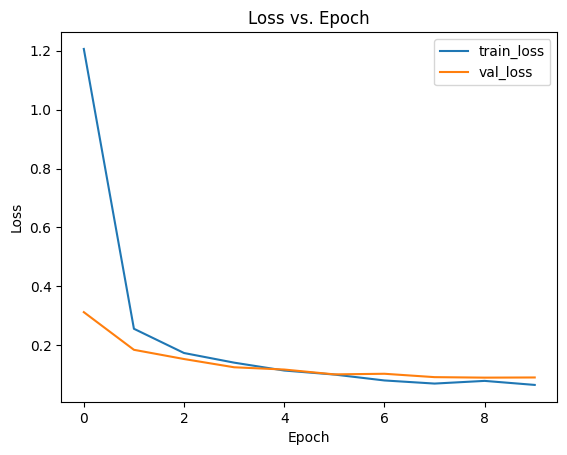

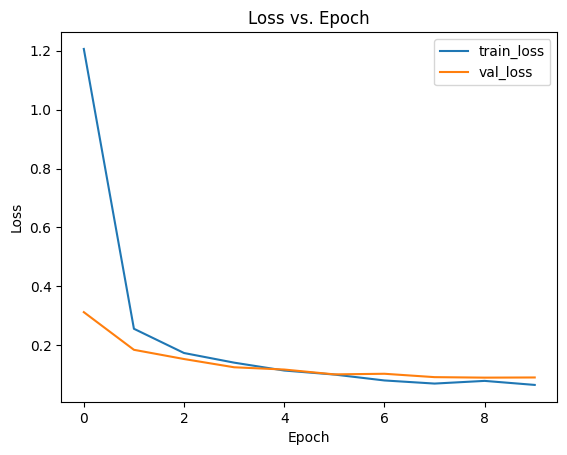

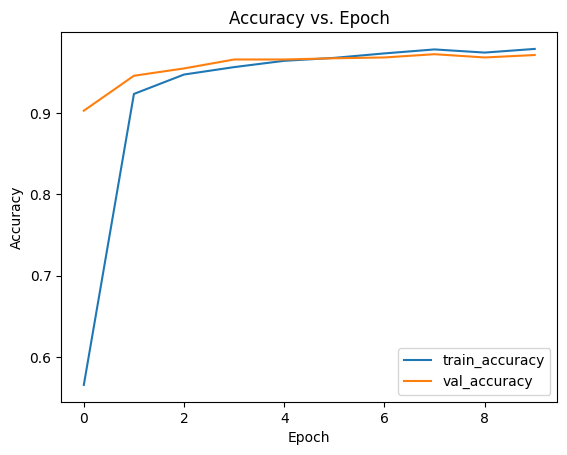

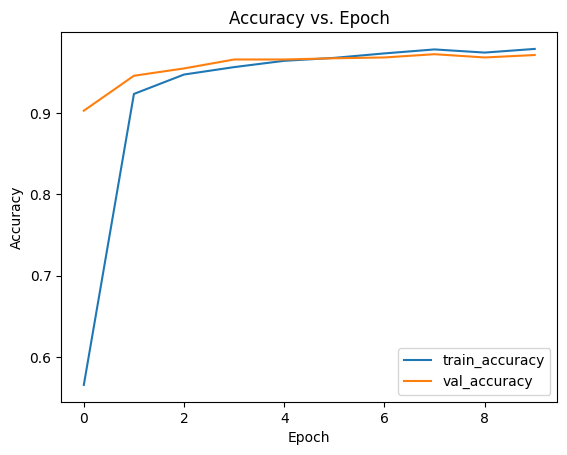

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
[INFO] Test Loss: 0.1264, Test Accuracy: 0.9685
[INFO] Precision: 0.9691, Recall: 0.9684, F1: 0.9685
[INFO] Test Loss: 0.1264, Test Accuracy: 0.9685
[INFO] Precision: 0.9691, Recall: 0.9684, F1: 0.9685
[INFO] Evaluate - Test Loss: 0.1264, Test Accuracy: 0.9685
[INFO] Evaluate - Test Loss: 0.1264, Test Accuracy: 0.9685


COMET WARNING: Couldn't retrieve and log Google Colab notebook content, reason: 'NoneType' object is not subscriptable
COMET WARNING: Couldn't retrieve and log Google Colab notebook content, reason: 'NoneType' object is not subscriptable
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : helpless_canal_5692
COMET INFO:     name                  : helpless_canal_5692
COMET INFO:     url                   

Epoch 1/10
Epoch 1/10
125/125 - 4s - 34ms/step - accuracy: 0.5192 - loss: 1.3299 - val_accuracy: 0.8990 - val_loss: 0.3464
125/125 - 4s - 34ms/step - accuracy: 0.5192 - loss: 1.3299 - val_accuracy: 0.8990 - val_loss: 0.3464
Epoch 2/10
Epoch 2/10
125/125 - 1s - 7ms/step - accuracy: 0.9233 - loss: 0.2551 - val_accuracy: 0.9440 - val_loss: 0.1804
125/125 - 1s - 7ms/step - accuracy: 0.9233 - loss: 0.2551 - val_accuracy: 0.9440 - val_loss: 0.1804
Epoch 3/10
Epoch 3/10
125/125 - 1s - 5ms/step - accuracy: 0.9499 - loss: 0.1607 - val_accuracy: 0.9605 - val_loss: 0.1326
125/125 - 1s - 5ms/step - accuracy: 0.9499 - loss: 0.1607 - val_accuracy: 0.9605 - val_loss: 0.1326
Epoch 4/10
Epoch 4/10
125/125 - 1s - 5ms/step - accuracy: 0.9601 - loss: 0.1245 - val_accuracy: 0.9585 - val_loss: 0.1349
125/125 - 1s - 5ms/step - accuracy: 0.9601 - loss: 0.1245 - val_accuracy: 0.9585 - val_loss: 0.1349
Epoch 5/10
Epoch 5/10
125/125 - 1s - 6ms/step - accuracy: 0.9696 - loss: 0.0989 - val_accuracy: 0.9705 - val_l

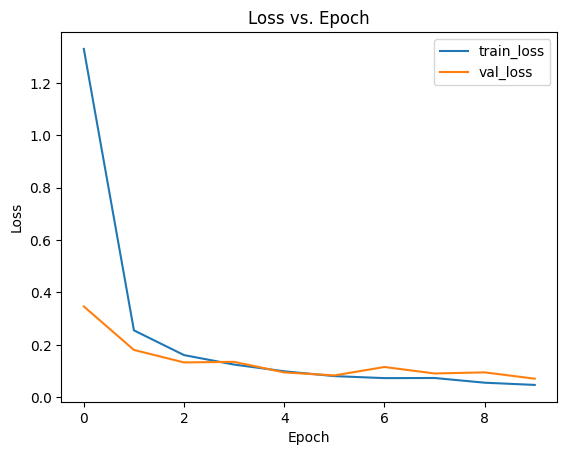

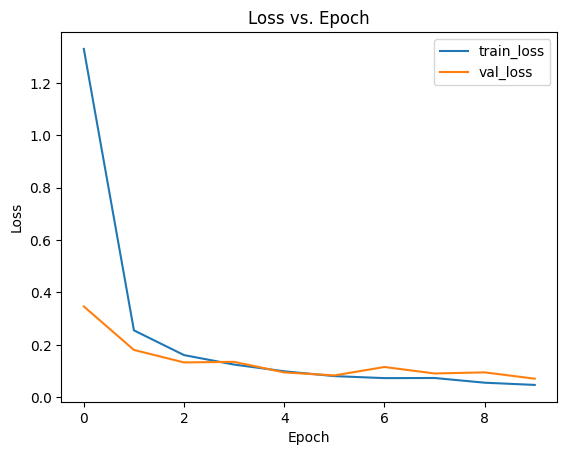

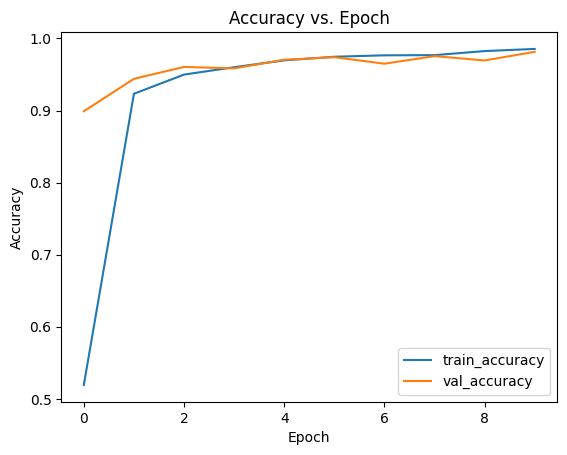

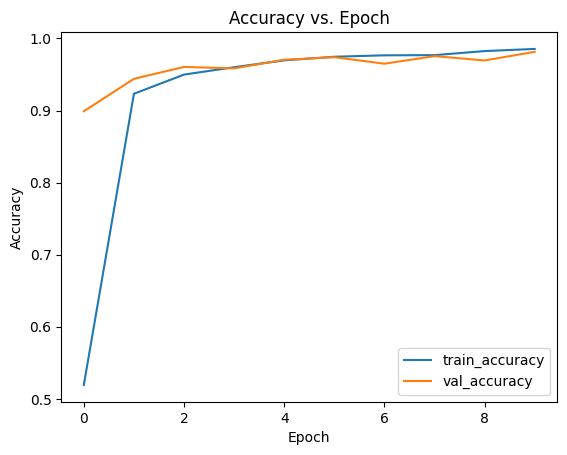

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
[INFO] Test Loss: 0.1251, Test Accuracy: 0.9660
[INFO] Precision: 0.9664, Recall: 0.9665, F1: 0.9661
[INFO] Test Loss: 0.1251, Test Accuracy: 0.9660
[INFO] Precision: 0.9664, Recall: 0.9665, F1: 0.9661
[INFO] Evaluate - Test Loss: 0.1251, Test Accuracy: 0.9660
[INFO] Evaluate - Test Loss: 0.1251, Test Accuracy: 0.9660


COMET WARNING: Couldn't retrieve and log Google Colab notebook content, reason: 'NoneType' object is not subscriptable
COMET WARNING: Couldn't retrieve and log Google Colab notebook content, reason: 'NoneType' object is not subscriptable
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : surprising_grouper_8450
COMET INFO:     name                  : surprising_grouper_8450
COMET INFO:     url           

Epoch 1/10
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


125/125 - 4s - 31ms/step - accuracy: 0.5630 - loss: 1.2207 - val_accuracy: 0.8945 - val_loss: 0.3451
125/125 - 4s - 31ms/step - accuracy: 0.5630 - loss: 1.2207 - val_accuracy: 0.8945 - val_loss: 0.3451
Epoch 2/10
Epoch 2/10
125/125 - 1s - 5ms/step - accuracy: 0.9178 - loss: 0.2598 - val_accuracy: 0.9440 - val_loss: 0.1803
125/125 - 1s - 5ms/step - accuracy: 0.9178 - loss: 0.2598 - val_accuracy: 0.9440 - val_loss: 0.1803
Epoch 3/10
Epoch 3/10
125/125 - 1s - 6ms/step - accuracy: 0.9532 - loss: 0.1579 - val_accuracy: 0.9550 - val_loss: 0.1546
125/125 - 1s - 6ms/step - accuracy: 0.9532 - loss: 0.1579 - val_accuracy: 0.9550 - val_loss: 0.1546
Epoch 4/10
Epoch 4/10
125/125 - 1s - 6ms/step - accuracy: 0.9604 - loss: 0.1284 - val_accuracy: 0.9645 - val_loss: 0.1100
125/125 - 1s - 6ms/step - accuracy: 0.9604 - loss: 0.1284 - val_accuracy: 0.9645 - val_loss: 0.1100
Epoch 5/10
Epoch 5/10
125/125 - 1s - 9ms/step - accuracy: 0.9668 - loss: 0.1018 - val_accuracy: 0.9745 - val_loss: 0.0846
125/125 - 

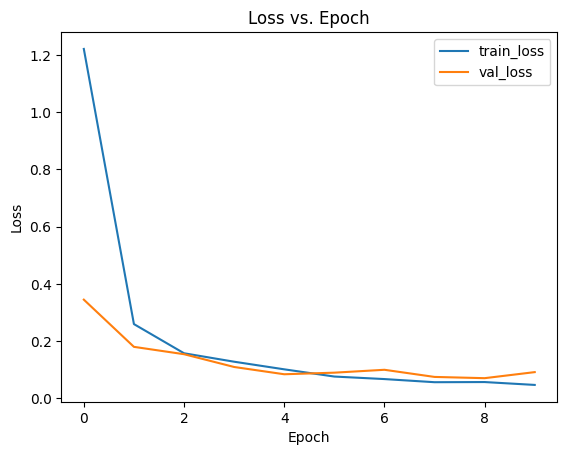

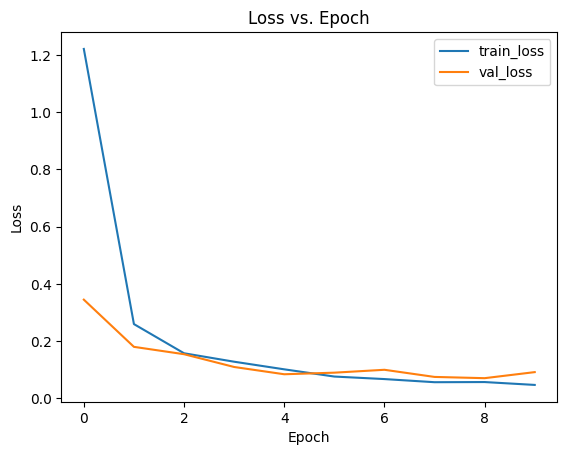

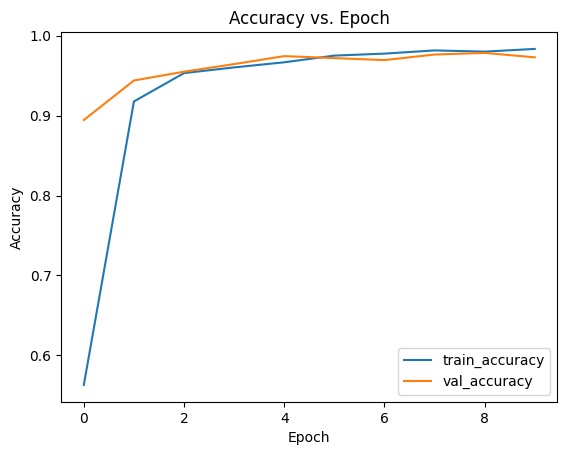

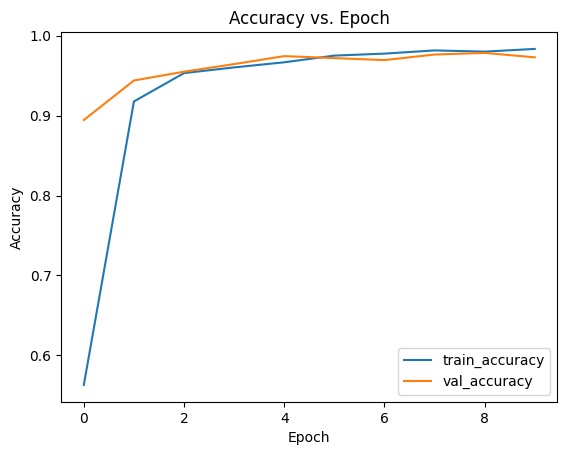

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
[INFO] Test Loss: 0.1401, Test Accuracy: 0.9660
[INFO] Precision: 0.9670, Recall: 0.9658, F1: 0.9661
[INFO] Test Loss: 0.1401, Test Accuracy: 0.9660
[INFO] Precision: 0.9670, Recall: 0.9658, F1: 0.9661
[INFO] Evaluate - Test Loss: 0.1401, Test Accuracy: 0.9660
[INFO] Evaluate - Test Loss: 0.1401, Test Accuracy: 0.9660


COMET WARNING: Couldn't retrieve and log Google Colab notebook content, reason: 'NoneType' object is not subscriptable
COMET WARNING: Couldn't retrieve and log Google Colab notebook content, reason: 'NoneType' object is not subscriptable
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : sheer_darby_8644
COMET INFO:     name                  : sheer_darby_8644
COMET INFO:     url                   : http

In [28]:
#  Make predictions with your model
for experiment in opt.get_experiments():
    # Optionally log any static parameters:
    experiment.log_parameter("epochs", 10)

    # Build the model
    model = build_model(experiment)

    # Train the model (with validation set)
    test_loss = train(
        experiment,
        model,
        X_train_part, y_train_part,  # training portion
        X_val, y_val,               # validation portion
        X_test, y_test              # test data
    )

    # Evaluate final performance (optional)
    evaluate(experiment, model, X_test, y_test)

    # End experiment for this set of hyperparams
    experiment.end()

In [ ]:
# Please identify the digit with the highest confidence prediction for the first image in the test dataset


[INFO] Training variant: baseline
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.1887 - loss: 2.1967 - val_accuracy: 0.6995 - val_loss: 0.8840
Epoch 2/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7250 - loss: 0.7769 - val_accuracy: 0.8385 - val_loss: 0.4744
Epoch 3/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.8506 - loss: 0.4557 - val_accuracy: 0.9005 - val_loss: 0.3127
Epoch 4/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8969 - loss: 0.3180 - val_accuracy: 0.9340 - val_loss: 0.2213
Epoch 5/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9222 - loss: 0.2418 - val_accuracy: 0.9370 - val_loss: 0.1995
Epoch 6/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9287 - loss: 0.2270 - val_accuracy: 0.9540 - val_loss: 0.1556
Epoch 7/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9384 - loss: 0.1932 - val_accuracy: 0.9495 - val_loss: 0.1537
Epoch 8/10
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9470 - loss: 0.1727 - val_accuracy: 0.9625 - val

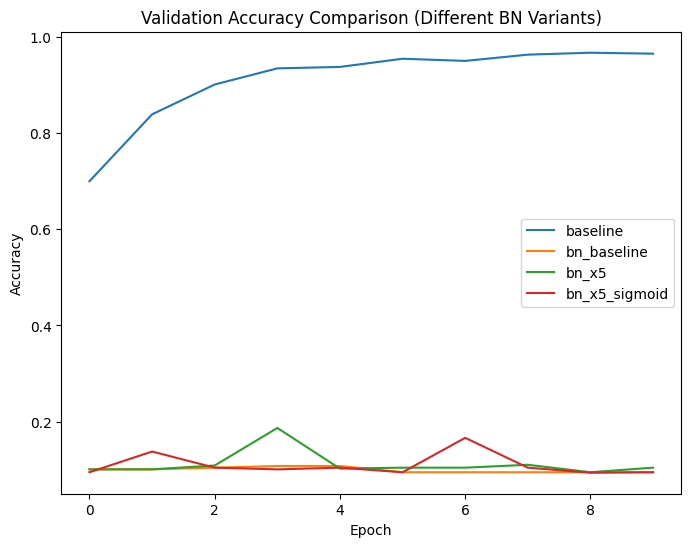

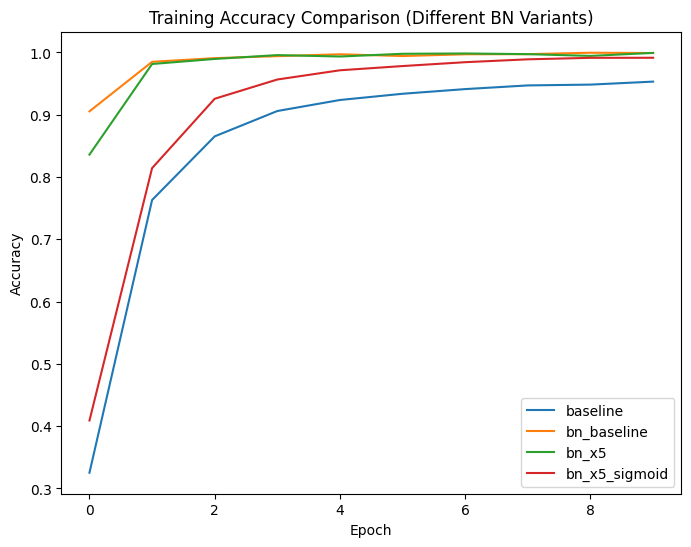

[TEST] baseline -> loss=0.1852, accuracy=0.9485
[TEST] bn_baseline -> loss=114.6799, accuracy=0.0925
[TEST] bn_x5 -> loss=55.7870, accuracy=0.1000
[TEST] bn_x5_sigmoid -> loss=3.3936, accuracy=0.0925


In [29]:
def build_model(variant="bn_baseline"):
    model = Sequential()

    if variant == "baseline":
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28,28,1)))
        model.add(MaxPooling2D((2,2), strides=1))
        model.add(Conv2D(32, (3, 3), activation='relu'))
        model.add(MaxPooling2D((2,2), strides=1))
        model.add(Flatten())
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(10, activation='softmax'))

    elif variant == "bn_baseline":
        model.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D((2,2), strides=1))

        model.add(Conv2D(32, (3, 3)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D((2,2), strides=1))

        model.add(Flatten())
        model.add(Dense(64))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dense(32))
        model.add(Activation('relu'))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(10, activation='softmax'))

    elif variant == "bn_x5":
        model.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2,2), strides=1))

        model.add(Conv2D(32, (3, 3)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2,2), strides=1))

        model.add(Flatten())
        model.add(Dense(64))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dense(32))
        model.add(Activation('relu'))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(10, activation='softmax'))

    elif variant == "bn_x5_sigmoid":
        model.add(Conv2D(32, (3, 3), input_shape=(28,28,1)))
        model.add(BatchNormalization())
        model.add(Activation('sigmoid'))
        model.add(MaxPooling2D((2,2), strides=1))

        model.add(Conv2D(32, (3, 3)))
        model.add(BatchNormalization())
        model.add(Activation('sigmoid'))
        model.add(MaxPooling2D((2,2), strides=1))

        model.add(Flatten())
        model.add(Dense(64))
        model.add(BatchNormalization())
        model.add(Activation('sigmoid'))
        model.add(Dense(32))
        model.add(Activation('sigmoid'))
        model.add(Dense(16, activation='sigmoid'))
        model.add(Dense(10, activation='softmax'))

    else:
        raise ValueError(f"Unknown variant: {variant}")

    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model


variants_to_try = [
    "baseline",
    "bn_baseline",
    "bn_x5",
    "bn_x5_sigmoid"
]
num_epochs = 10
batch_size = 64

histories = {}
for variant in variants_to_try:
    print(f"\n[INFO] Training variant: {variant}")
    model = build_model(variant)
    hist = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=num_epochs,
        batch_size=batch_size,
        verbose=1
    )
    histories[variant] = hist


plt.figure(figsize=(8,6))
for variant in variants_to_try:
    plt.plot(histories[variant].history['val_accuracy'], label=f"{variant}")
plt.title("Validation Accuracy Comparison (Different BN Variants)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


plt.figure(figsize=(8,6))
for variant in variants_to_try:
    plt.plot(histories[variant].history['accuracy'], label=f"{variant}")
plt.title("Training Accuracy Comparison (Different BN Variants)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

for variant in variants_to_try:
    model = build_model(variant)
    trained_model = histories[variant].model
    test_loss, test_acc = trained_model.evaluate(X_test, y_test, verbose=0)
    print(f"[TEST] {variant} -> loss={test_loss:.4f}, accuracy={test_acc:.4f}")